# Coefficients of Fractional Parentage

In [23]:
import re
import numpy as np
import sympy as sp
from collections import OrderedDict as odict
from collections import namedtuple as ntuple
from functools import reduce
from itertools import product
%load_ext autoreload
%autoreload 2
import tensorops as to
from notation import *
from functools import lru_cache
from qdef import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## States & Coefficients of Fractional Parentage : Parsing

This block produces two datasets state_labels.pkl and cfps.pkl.

In addition to these a csv version is also produced.

In [141]:
# named tuples
State_label = ntuple('state',['Seniority','Sup_irrep'])
Term_label = ntuple('Term',['S','L','W'])
Cfp_template = ntuple('CFP',['offspring', 'parent'])

primes = [2,3,5,7,11,13,17,19,23,29,31]
primes = list(map(sp.S, primes))

In [142]:
def parse_term(term_string):
    term_multi, term_L = int(term_string[0]), l_notation_switch(term_string[1])
    term_S = sp.S(term_multi-1)/2
    if len(term_string) == 2:
        term_idx = 1
    else:
        term_idx = int(term_string[2])
    return Term_label(term_S, term_L, term_idx)

def splitter(string):
    split = ''
    pchar = ''
    string = string.replace('.','-')
    for char in string:
        if char == '-':
            split += ' '
        if char in '0123456789':
            if pchar in '0123456789':
                split += ' '
        split += char
        pchar = char
    return list(map(int,split.strip().split(' ')))

In [144]:
# parse states

states = odict()
state_lines = open('./data/k_states.txt','r').read().split('\n')
for line_num, line in enumerate(state_lines):
    if line == '':
        continue
    if line[0] == '-':
        # parsing a new configuration
        num_electrons = int(line[2])
        lstr = line[1]
        l = l_notation_switch(line[1])
        states[(l, num_electrons)] = []
    else:
        term_symbol = line.split(':')[0].upper()
        if len(term_symbol) == 3:
            term_idx = int(term_symbol[-1])
        else:
            term_idx = 1
        term_symbol = Term_label(sp.S(int(term_symbol[0])-1)/2, 
                                l_notation_switch(term_symbol[1]), term_idx)
        if lstr == 'p':
            γ= State_label(None, None)
        elif lstr == 'd':
            γ = line.split(':')[-1]
            γ = '%s(%s)' % (γ[0], γ[1:])
            γ = State_label(int(γ[0]), γ[1:])
        elif lstr == 'f':
            γ = line.split(':')[-1]
            γ = '%s(%s)(%s)' % (γ[0], γ[1:4],γ[4:])
            γ = State_label(int(γ[0]), γ[1:])
        states[(l, num_electrons)].append((term_symbol, γ))

In [145]:
data = open('./data/allcfps.txt','r').read().split('\n')
all_cfps = odict()
for line in data:
    if line == '':
        continue
    if line[0] == "#":
        continue
    if line[0] == '-':
        sector = line[1:]
        term_labels = []
        values = []
    elif ':' in line:
        offspring = line.split(':')[0]
        parents = line.split(':')[1].split(' ')
        family = [(offspring.upper(),parent.upper()) for parent in parents]
        term_labels.extend(family)
    else:
        chunks = splitter(line)
        a0 = chunks[0]
        if len(chunks) > 1:
            chunks = chunks[1:]
            tail = sp.sqrt(reduce(sp.core.mul.Mul,[p**a for p,a in zip(primes,chunks) if a!=0]))
            values.append(a0*tail)
        else:
            values.append(a0)
    if len(values) == len(term_labels):
        if len(values):
            pairs = list(zip(term_labels, values))
            sector_l, sector_n = l_notation_switch(sector[0]), int(sector[1])
            sector = (sector_l, sector_n)
            all_cfps[sector] = odict()
            for key, val in pairs:
                offspring, parent = key
                offspring_term = parse_term(offspring)
                parent_term = parse_term(parent)
                all_cfps[sector][Cfp_template(offspring_term, parent_term)] = val

In [146]:
cfp2latex = r'{{\langle}}{l}^{n_par}\,{{}}^{Multi_par}\!{L_par}^{{({W_par})}}|\Big\}}\,\,|{l}^{n_off}\,{{}}^{Multi_off}\!{L_off}^{{({W_off})}}{{\rangle}}'

In [147]:
from IPython.display import Math, display

In [201]:
latex_lines = []
for key, cfps in all_cfps.items():
    lstring = l_notation_switch(key[0])
    n = key[1]
    latex_lines.append('\\section{$%s^%d$}\n' % (lstring,n))
    done_offspring = []
    for idx, (cfp_key, cpf_value) in enumerate(cfps.items()):
        term_off = cfp_key.offspring
        term_par = cfp_key.parent
        S_off, L_off, W_off = term_off
        if (S_off,L_off,W_off) not in done_offspring:
            if idx != 0:
                # latex_lines.append('\n')
                latex_lines.append('\\end{align*}')
            latex_lines.append('\\subsection{${}^%d{%s}^{(%d)}$}\n' % (2*S_off+1,l_notation_switch(L_off).upper(), W_off))
            latex_lines.append('\\begin{align*}')
        S_par, L_par, W_par = term_par
        lhs = cfp2latex.format(l=lstring, n_par=n-1,W_par=W_par,Multi_par=2*S_par+1,L_par=l_notation_switch(L_par).upper(),
                                n_off=n, W_off=W_off,Multi_off=2*S_off+1,L_off=l_notation_switch(L_off).upper())
        rhs = sp.latex(cpf_value)
        line = '%s &= %s \\\\' % (lhs, rhs)
        latex_lines.append(line)
        done_offspring.append((S_off,L_off,W_off))
    latex_lines.append('\\end{align*}')
    export_fname = '/Users/juan/Library/Mobile Documents/com~apple~CloudDocs/iCloudFiles/Theoretical Division/CFPs.tex'
    open(export_fname,'w').write('\n'.join(latex_lines))

In [149]:
print(latex_lines[1])

${\langle}p^1,1,{}^2\!P|\}\,\,|p^2,1,{}^3\!P{\rangle} = 1$


In [104]:
Math(cfp2latex.format(l=lstring, n_par=n-1,W_par=W_par,Multi_par=2*S_par+1,L_par=l_notation_switch(L_par).upper(),
                                n_off=n, W_off=W_off,Multi_off=2*S_off+1,L_off=l_notation_switch(L_off).upper()))

<IPython.core.display.Math object>

## One - Body Operators

$\hat{F}=\sum_{i=1}^n \hat{f}_i$

For two determinantal states $|\Omega'\rangle$, $|\Omega\rangle$:

$\langle\Omega|\hat{F}|\Omega'\rangle = n \sum_{\Omega',\omega,\omega'} \langle\Omega|\bar{\Omega}\omega\rangle \langle\bar{\Omega}{\omega'}|{\Omega'}\rangle \langle{\omega_n}|{\hat{f}_n}|\omega_n'\rangle$

Where 

$\langle\Omega|\bar{\Omega}\omega\rangle$ are fractional parentage coefficients, 

sums over $\omega$ is a sum over $m_l=-l,-l+1,...,l-1,l$ and $m_s=-1/2,1/2$,

sum over $\bar{\Omega}$ is a sum over all the quantum numbers that define $l^{n-1}$ states, that is a sum over all $\gamma,S,MS,L,ML$.

As an example let's calculate the matrix elements of the one-body operator corresponding to the interaction of electrons with the charge of the nucleus. The result being trivial this allows for a simple sanity check.

Since the Coulomb repulsion involves no spin the sums over ω and ω' are only sums over ml and ml'.

A single particle operator will simply be a dictionary whose keys are (ml,ml').

In [ ]:
# l = 2
# n = 2
# HALF = sp.S(1)/2
# f = odict()
# for ml in [-2,-1,0,1,2]:
#     for mlp in [-2,-1,0,1,2]:
#         f[(ml,mlp)] = sp.randprime(1,15)

The cfps are another dictionary whose keys are a 3-tuple (Ω'ω,Ω).

For this 2-electron example we need to grab the CFPs that link two and three electrons.

In [ ]:
# cfps = all_cfps[n]

We also need to pin down the terms that correspond to this configuration. In this case the "states" can simply be labeled by their terms.

In [ ]:
# Ωs = [term for term, _ in states[n]]

The cpfs themselves define the ranges for the sum.

In [ ]:
# Ωbs = [key.ket_term for key in cfps.keys()]
# Ωbs = list(set(Ωbs))
# Ωbs  

In [ ]:
# F = dict()
# mls = [-2,-1,0,1,2]
# # iterate over all combinations of Ωs, Ωs
# cfps = all_cfps[n]
# for Ω, Ωp in product(Ωs, Ωs):
#     summands = []
#     for Ωb in Ωbs:
#         # in this example the CFPs don't depend
#         # on ml or ml' so we might as well
#         # summon them here
#         fp0 = cfps[Cfp_template(Ω, Ωb)]
#         fp1 = cfps[Cfp_template(Ωp, Ωb)]
#         for ml, mlp in product(mls, mls):
#             # summand = fp0*fp1*sp.Symbol('\\langle{ml=%d}|f|{ml\'=%d}\\rangle' % (ml,mlp))
#             if ml != mlp:
#                 continue
#             summand = fp0*fp1*sp.Symbol('E') #*sp.Symbol('\\langle{%d}|f|{%d}\\rangle' % (ml,mlp))
#             summands.append(summand)
#     F[(Ω, Ωp)] = n*sum(summands)
# F[(Ω, Ωp)]

In [ ]:
# # parse CFPs

# all_cfps = odict()
# cfp_lines = open('./data/cfp.txt','r').read().split('\n')

# def parse_term(term_string):
#     term_multi, term_L = int(term_string[0]), l_notation_switch(term_string[1])
#     term_S = sp.S(term_multi-1)/2
#     if len(term_string) == 2:
#         term_idx = 1
#     else:
#         term_idx = int(term_string[2])
#     return Term_label(term_S, term_L, term_idx)

# for line_num, line in enumerate(cfp_lines):
#     if line == '':
#         continue
#     if line[0] == "#":
#         continue
#     line = line.replace('\t','')
#     if line[0] == '-':
#         # parsing a new stage
#         stage = int(line[2])
#         if stage not in all_cfps:
#             all_cfps[stage] = odict()
#     else:
#         chunks = line.split(' ')
#         offspring, parent = chunks[:2]
#         acfp = primes_to_sympy(' '.join(chunks[2:]))
#         offspring_term = parse_term(offspring)
#         parent_term = parse_term(parent)
#         all_cfps[stage][Cfp_template(offspring_term, parent_term)] = acfp

In [160]:
HALF = sp.S(1)/2

# @lru_cache(maxsize=None)
def Ω_coeff(l, n, parent_qnums, ω, offspring_qnums):
    '''
    This function returns the coefficient
    <lⁿ⁻¹ W* S* MS* L* ML*; l ms ml | lⁿW S MS L ML>
    Parameters
    ----------
    n (int): number of electrons
    Returns
    -------

    '''
    s = HALF
    Wb, Sb, MSb, Lb, MLb = parent_qnums
    l, ms, ml = ω
    W, S, MS, L, ML = offspring_qnums
    # grab the cfp
    parent_term = Term_label(Sb, Lb, Wb)
    offspring_term = Term_label(S, L, W)
    cfp_key = Cfp_template(offspring_term, parent_term)
    if cfp_key not in all_cfps[(l,n)]:
        return 0
    cfp = all_cfps[(l,n)][cfp_key]
    # Vector Coupling coeffs
    vcS = to.VC_coeff((Sb,MSb,s,ms), (Sb, s, S, MS))
    if vcS == 0:
        return 0
    vcL = to.VC_coeff((Lb,MLb,l,ml), (Lb, l, L, ML))
    val = vcS * vcL * cfp
    if val:
        print(vcS, vcL, cfp)
    return val

# @lru_cache(maxsize=None)
def mrange(j):
    '''
    Give a j get a list with corresponding mj.

    Parameters
    ----------
    j  (int or half-int): angular momentum

    Returns
    -------
    (list) [-j, -j+1, ..., j-1, j]
    '''
    # returns ranges that work for half integers
    assert int(j*2) == 2*j, "j should be integer or half-integer"
    assert j>=0, "j should be non-negative"
    j = sp.S(int(2*j))/2
    val = list((-j+i) for i in range(int(2*j+1)))
    return val

In [163]:
l = 2
n = 2
mls = mrange(l)
HALF = sp.S(1)/2

cfps = all_cfps[(l,n)]
terms = [term for term, _ in states[(l,n)]] # the terms present in the lⁿ configuration
terms = list(set(terms))
term_bar_s = [term for term, _ in states[(l,n-1)]] # the terms present in the lⁿ⁻¹ configuration
term_bar_s = list(set(term_bar_s))

F = dict()
Ms_s = [-HALF, HALF]
printed = []
num_iters = 0

for term_row, term_col in product(terms, terms): # loop over the terms for rows and columns
    S, L, W = term_row # unpack term_row
    Sp, Lp, Wp = term_col # unpack term_col
    # make the ranges for ML, MLp, MS, MSp
    # ML_s, MLp_s = mrange(L), mrange(Lp)
    # MS_s, MSp_s = mrange(S), mrange(Sp)
    # A shortcut
    ML_s, MLp_s = [L], [Lp]
    MS_s, MSp_s = [S], [Sp]
    for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s): # this loops over the enclosed states
        Ω = (W, S, MS, L, ML) # full address of row state
        Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
        # Shortcircuit debug
        if Ω != (1, 0, 0, 0 , 0) :
            continue
        if Ωp != (1, 0, 0, 0, 0) :
            continue
        summands = []
        for term_bar in term_bar_s: # this iterates over the terms of lⁿ⁻¹
            Sb, Lb, Wb = term_bar # unpack term_bar
            MSb_s, MLb_s = mrange(Sb), mrange(Lb)
            for MSb, MLb in product(MSb_s, MLb_s):
                Ωb = (Wb, Sb, MSb, Lb, MLb) # full address of an lⁿ⁻¹ state
                for ml, ms in product(mls, Ms_s): # Σ ω, ωp assumming δ(ml,mlp)δ(ms,msp)
                    mlp, msp = ml, ms
                    num_iters += 1
                    fp0 = Ω_coeff(l, n, Ωb, (l, ms, ml), Ω)
                    fp1 = Ω_coeff(l, n, Ωb, (l, msp, mlp), Ωp)
                    printout = '(%d%s%d-%d%s%d)(%d%s%d-%d%s%d)' % (Ω[1]*2+1, l_notation_switch(Ω[3]).upper(), Ω[0], Ωb[1]*2+1, l_notation_switch(Ωb[3]).upper(),Ωb[0], Ωp[1]*2+1, l_notation_switch(Ωp[3]).upper(), Ωp[0], Ωb[1]*2+1, l_notation_switch(Ωb[3]).upper(),Ωb[0])
                    # if printout not in printed:
                    #     print(printout)
                    #     printed.append(printout)
                    summand = fp0 * fp1 * sp.Symbol('E') # * sp.Symbol(printout)
                    summands.append(summand)
        F[(Ω, Ωp)] = n*sum(summands)
        if F[(Ω, Ωp)] != 0:
            if F[(Ω, Ωp)] != n*sp.Symbol('E'):
                print(Ω, Ωp)
                display(F[(Ω, Ωp)])
print(set(F.values()))


-sqrt(2)/2 sqrt(5)/5 1
-sqrt(2)/2 sqrt(5)/5 1
-sqrt(2)/2 -sqrt(5)/5 1
-sqrt(2)/2 -sqrt(5)/5 1
-sqrt(2)/2 sqrt(5)/5 1
-sqrt(2)/2 sqrt(5)/5 1
-sqrt(2)/2 -sqrt(5)/5 1
-sqrt(2)/2 -sqrt(5)/5 1
-sqrt(2)/2 sqrt(5)/5 1
-sqrt(2)/2 sqrt(5)/5 1
sqrt(2)/2 sqrt(5)/5 1
sqrt(2)/2 sqrt(5)/5 1
sqrt(2)/2 -sqrt(5)/5 1
sqrt(2)/2 -sqrt(5)/5 1
sqrt(2)/2 sqrt(5)/5 1
sqrt(2)/2 sqrt(5)/5 1
sqrt(2)/2 -sqrt(5)/5 1
sqrt(2)/2 -sqrt(5)/5 1
sqrt(2)/2 sqrt(5)/5 1
sqrt(2)/2 sqrt(5)/5 1
{2*E}


In [ ]:
data = '''1.330.10.1
1010.1.1
1.622.1.1.11
.1.6.4.1.10.11
.1.50.11.1
1.11.23.1.1
1.50.210.1
.1.102.1.1
.1.31.2.10.10002'''
dlines = data.split('\n')
for dline in dlines:
    print(splitter(dline))

[1, -3, 3, 0, -1, 0, -1]
[1, 0, 1, 0, -1, -1]
[1, -6, 2, 2, -1, -1, -1, 1]
[-1, -6, -4, -1, -1, 0, -1, 1]
[-1, -5, 0, -1, 1, -1]
[1, -1, 1, -2, 3, -1, -1]
[1, -5, 0, -2, 1, 0, -1]
[-1, -1, 0, 2, -1, -1]
[-1, -3, 1, -2, -1, 0, -1, 0, 0, 0, 2]


In [ ]:
set(F.values())

{0, 5*E}

In [ ]:
for key, val in F.items():
    if val not in [0,4*sp.Symbol('E')]:
        print(key,val)

In [ ]:
set(F.values())

{0, 4*E}

In [ ]:
primes_to_sympy('-1 0 0 0 0 1')

-sqrt(11)

In [ ]:
(2,1,1,3,3)

In [ ]:
 Ω = (W, S, MS, L, ML) # full address of row state

In [ ]:
to.paired_kron(1,1,2,3)

0

In [ ]:
primes = [2,3,5,7,11,13,17,19,23,29,31]
primes = list(map(sp.S, primes))

In [ ]:
all_c

## One - Body Operators (using better CFPs) ugh i need to do this from scratch

$\hat{F}=\sum_{i=1}^n \hat{f}_i$

For two determinantal states $|\Omega'\rangle$, $|\Omega\rangle$:

$\langle\Omega|\hat{F}|\Omega'\rangle = n \sum_{\Omega',\omega,\omega'} \langle\Omega|\bar{\Omega}\omega\rangle \langle\bar{\Omega}{\omega'}|{\Omega'}\rangle \langle{\omega_n}|{\hat{f}_n}|\omega_n'\rangle$

Where 

$\langle\Omega|\bar{\Omega}\omega\rangle$ are fractional parentage coefficients, 

sums over $\omega$ is a sum over $m_l=-l,-l+1,...,l-1,l$ and $m_s=-1/2,1/2$,

sum over $\bar{\Omega}$ is a sum over all the quantum numbers that define $l^{n-1}$ states, that is a sum over all $\gamma,S,MS,L,ML$.

As an example let's calculate the matrix elements of the one-body operator corresponding to the interaction of electrons with the charge of the nucleus. The result being trivial this allows for a simple sanity check.

Since the Coulomb repulsion involves no spin the sums over ω and ω' are only sums over ml and ml'.

A single particle operator will simply be a dictionary whose keys are (ml,ml').

In [11]:
# l = 2
# n = 2
# HALF = sp.S(1)/2
# f = odict()
# for ml in [-2,-1,0,1,2]:
#     for mlp in [-2,-1,0,1,2]:
#         f[(ml,mlp)] = sp.randprime(1,15)

The cfps are another dictionary whose keys are a 3-tuple (Ω'ω,Ω).

For this 2-electron example we need to grab the CFPs that link two and three electrons.

In [12]:
# cfps = all_cfps[n]

We also need to pin down the terms that correspond to this configuration. In this case the "states" can simply be labeled by their terms.

In [13]:
# Ωs = [term for term, _ in states[n]]

The cpfs themselves define the ranges for the sum.

In [14]:
# Ωbs = [key.ket_term for key in cfps.keys()]
# Ωbs = list(set(Ωbs))
# Ωbs  

In [15]:
# F = dict()
# mls = [-2,-1,0,1,2]
# # iterate over all combinations of Ωs, Ωs
# cfps = all_cfps[n]
# for Ω, Ωp in product(Ωs, Ωs):
#     summands = []
#     for Ωb in Ωbs:
#         # in this example the CFPs don't depend
#         # on ml or ml' so we might as well
#         # summon them here
#         fp0 = cfps[Cfp_template(Ω, Ωb)]
#         fp1 = cfps[Cfp_template(Ωp, Ωb)]
#         for ml, mlp in product(mls, mls):
#             # summand = fp0*fp1*sp.Symbol('\\langle{ml=%d}|f|{ml\'=%d}\\rangle' % (ml,mlp))
#             if ml != mlp:
#                 continue
#             summand = fp0*fp1*sp.Symbol('E') #*sp.Symbol('\\langle{%d}|f|{%d}\\rangle' % (ml,mlp))
#             summands.append(summand)
#     F[(Ω, Ωp)] = n*sum(summands)
# F[(Ω, Ωp)]

In [16]:
# # parse CFPs

# all_cfps = odict()
# cfp_lines = open('./data/cfp.txt','r').read().split('\n')

# def parse_term(term_string):
#     term_multi, term_L = int(term_string[0]), l_notation_switch(term_string[1])
#     term_S = sp.S(term_multi-1)/2
#     if len(term_string) == 2:
#         term_idx = 1
#     else:
#         term_idx = int(term_string[2])
#     return Term_label(term_S, term_L, term_idx)

# for line_num, line in enumerate(cfp_lines):
#     if line == '':
#         continue
#     if line[0] == "#":
#         continue
#     line = line.replace('\t','')
#     if line[0] == '-':
#         # parsing a new stage
#         stage = int(line[2])
#         if stage not in all_cfps:
#             all_cfps[stage] = odict()
#     else:
#         chunks = line.split(' ')
#         offspring, parent = chunks[:2]
#         acfp = primes_to_sympy(' '.join(chunks[2:]))
#         offspring_term = parse_term(offspring)
#         parent_term = parse_term(parent)
#         all_cfps[stage][Cfp_template(offspring_term, parent_term)] = acfp

In [17]:
from qdef import CFP_fun

In [37]:
CFP_1 = CFP_fun(1)
CFP_1_str = CFP_fun(1, string_notation=True)

Loading data for 1-body coefficients of fractional parentage...
Loading data for 1-body coefficients of fractional parentage...


In [38]:
display(CFP_1_str('d 4 5D1 4P1 2D1'))

sqrt(30)/10

In [74]:
HALF = sp.S(1)/2

@lru_cache(maxsize=None)
def Ω_coeff(l, n, parent_qnums, ω, daughter_qnums):
    '''
    This function returns the coefficient
    <lⁿ⁻¹ W* S* MS* L* ML*; l ms ml | lⁿW S MS L ML>
    Parameters
    ----------
    n (int): number of electrons
    Returns
    -------

    '''
    s = HALF
    Wb, Sb, MSb, Lb, MLb = parent_qnums
    l, ms, ml = ω
    W, S, MS, L, ML = daughter_qnums
    # grab the cfp
    parent1_term = (Sb, Lb, Wb)
    parent2_term = (sp.S(1)/2, l, 1)
    daughter_term = (n, S, L, W)
    cfp_key = (l, n,
               *daughter_term,
               *parent1_term,
               *parent2_term)

    cfp = CFP_1(*cfp_key)
    # Vector Coupling coeffs
    vcS = to.VC_coeff((Sb,MSb,s,ms), (Sb, s, S, MS))
    if vcS == 0:
        return 0
    vcL = to.VC_coeff((Lb,MLb,l,ml), (Lb, l, L, ML))
    val = vcS * vcL * cfp
    return val

@lru_cache(maxsize=None)
def mrange(j):
    '''
    Give a j get a list with corresponding mj.

    Parameters
    ----------
    j  (int or half-int): angular momentum

    Returns
    -------
    (list) [-j, -j+1, ..., j-1, j]
    '''
    # returns ranges that work for half integers
    assert int(j*2) == 2*j, "j should be integer or half-integer"
    assert j>=0, "j should be non-negative"
    j = sp.S(int(2*j))/2
    val = list((-j+i) for i in range(int(2*j+1)))
    return val

In [75]:
import pickle
all_terms = pickle.load(open('./data/all_term_labels.pkl','rb'))

In [76]:
l = 3
n = 2
mls = mrange(l)
HALF = sp.S(1)/2

terms = all_terms[(all_terms['l'] == l) & (all_terms['n'] == n)][['S','L','idx']].to_records(index=False)
terms = list(terms)

term_bar_s = all_terms[(all_terms['l'] == l) & (all_terms['n'] == (n-1))][['S','L','idx']].to_records(index=False)
term_bar_s = list(term_bar_s)

F = dict()
Ms_s = [-HALF, HALF]
printed = []
num_iters = 0

for term_row, term_col in product(terms, terms): # loop over the terms for rows and columns
    S, L, W = term_row # unpack term_row
    Sp, Lp, Wp = term_col # unpack term_col
    # make the ranges for ML, MLp, MS, MSp
    # ML_s, MLp_s = mrange(L), mrange(Lp)
    # MS_s, MSp_s = mrange(S), mrange(Sp)
    # A shortcut
    ML_s, MLp_s = [L], [Lp]
    MS_s, MSp_s = [S], [Sp]
    for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s): # this loops over the enclosed states
        Ω = (W, S, MS, L, ML) # full address of row state
        Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
        # Shortcircuit debug
        # if Ω != (1, 0, 0, 6, 6) :
        #     continue
        # if Ωp != (2, 0, 0, 6, 6) :
        #     continue
        summands = []
        for term_bar in term_bar_s: # this iterates over the terms of lⁿ⁻¹
            Sb, Lb, Wb = term_bar # unpack term_bar
            MSb_s, MLb_s = mrange(Sb), mrange(Lb)
            for MSb, MLb in product(MSb_s, MLb_s):
                Ωb = (Wb, Sb, MSb, Lb, MLb) # full address of an lⁿ⁻¹ state
                for ml, ms in product(mls, Ms_s): # Σ ω, ωp assumming δ(ml,mlp)δ(ms,msp)
                    mlp, msp = ml, ms
                    num_iters += 1
                    fp0 = Ω_coeff(l, n, Ωb, (l, ms, ml), Ω)
                    if fp0 == 0:
                        continue
                    fp1 = Ω_coeff(l, n, Ωb, (l, msp, mlp), Ωp)
                    if fp1 == 0:
                        continue
                    # printout = '(%d%s%d-%d%s%d)(%d%s%d-%d%s%d)' % (Ω[1]*2+1, l_notation_switch(Ω[3]).upper(), Ω[0], Ωb[1]*2+1, l_notation_switch(Ωb[3]).upper(),Ωb[0], Ωp[1]*2+1, l_notation_switch(Ωp[3]).upper(), Ωp[0], Ωb[1]*2+1, l_notation_switch(Ωb[3]).upper(),Ωb[0])
                    # if printout not in printed:
                    #     print(printout)
                    #     printed.append(printout)
                    summand = fp0 * fp1 * sp.Symbol('E') # * sp.Symbol(printout)
                    summands.append(summand)
        F[(Ω, Ωp)] = n*sum(summands)
        if F[(Ω, Ωp)] != 0:
            if F[(Ω, Ωp)] != n*sp.Symbol('E'):
                print(Ω, Ωp)
                display(F[(Ω, Ωp)])
print(set(F.values()))


KeyError: (3, 2, 2, 0, 0)

In [63]:
CFP_1?

Signature: CFP_1(l, n, S, L, W, S_p, L_p, W_p, S_pp, L_pp, W_pp, fill_missing=False)
Docstring:
Returns the 1-body coefficient of fractional parentage.  If
coefficient  is  physical  but  not immediately available, a series of
identities are tried out to see if it can be computed thus.

Parameters
----------
l (int): orbital angular momentum of constituent electrons
n (int): how many electrons in configuration
S (half-int or int): S of daughter
L (int): L of daughter
W (int): index of daughter
S_p (half-int or int): S of parent_1
L_p (int): L of parent_1
W_p (int): index of parent_1
S_pp (half-int or int): S of parent_2
L_pp (int): L of parent_2
W_pp (int): index of parent_2
fill_missing (bool): if True then 0 is returned for key not found, unsafe.

Returns
-------
CFP (sp.S): symbolic expression for coefficent of fractional parentage
File:      ~/ZiaLab/Codebase/qdef/qdef.py
Type:      function


In [ ]:
data = '''1.330.10.1
1010.1.1
1.622.1.1.11
.1.6.4.1.10.11
.1.50.11.1
1.11.23.1.1
1.50.210.1
.1.102.1.1
.1.31.2.10.10002'''
dlines = data.split('\n')
for dline in dlines:
    print(splitter(dline))

[1, -3, 3, 0, -1, 0, -1]
[1, 0, 1, 0, -1, -1]
[1, -6, 2, 2, -1, -1, -1, 1]
[-1, -6, -4, -1, -1, 0, -1, 1]
[-1, -5, 0, -1, 1, -1]
[1, -1, 1, -2, 3, -1, -1]
[1, -5, 0, -2, 1, 0, -1]
[-1, -1, 0, 2, -1, -1]
[-1, -3, 1, -2, -1, 0, -1, 0, 0, 0, 2]


In [ ]:
set(F.values())

{0, 5*E}

In [ ]:
for key, val in F.items():
    if val not in [0,4*sp.Symbol('E')]:
        print(key,val)

In [ ]:
set(F.values())

{0, 4*E}

In [ ]:
primes_to_sympy('-1 0 0 0 0 1')

-sqrt(11)

In [ ]:
(2,1,1,3,3)

In [ ]:
 Ω = (W, S, MS, L, ML) # full address of row state

In [ ]:
to.paired_kron(1,1,2,3)

0

In [ ]:
primes = [2,3,5,7,11,13,17,19,23,29,31]
primes = list(map(sp.S, primes))

## One - Body Operators (using better CFPs)

In [1]:
import pickle
all_terms = pickle.load(open('./data/all_term_labels.pkl','rb'))

In [198]:
from qdef import CFP_fun

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


In [199]:
CFP_1 = CFP_fun(1)
CFP_1_str = CFP_fun(1, string_notation=True)

Loading data for 1-body coefficients of fractional parentage...
Loading data for 1-body coefficients of fractional parentage...


In [200]:
# def Ω_coeff(l, n, parent_qnums, ω, offspring_qnums):
#     '''
#     This function returns the coefficient
#     <lⁿ⁻¹ W* S* MS* L* ML*; l ms ml | lⁿW S MS L ML>
#     Parameters
#     ----------
#     n (int): number of electrons
#     Returns
#     -------

#     '''
#     s = HALF
#     Wb, Sb, MSb, Lb, MLb = parent_qnums
#     l, ms, ml = ω
#     W, S, MS, L, ML = offspring_qnums
#     # grab the cfp
#     parent_term = Term_label(Sb, Lb, Wb)
#     offspring_term = Term_label(S, L, W)
#     cfp_key = Cfp_template(offspring_term, parent_term)
#     if cfp_key not in all_cfps[(l,n)]:
#         return 0
#     cfp = all_cfps[(l,n)][cfp_key]
#     # Vector Coupling coeffs
#     vcS = to.VC_coeff((Sb,MSb,s,ms), (Sb, s, S, MS))
#     if vcS == 0:
#         return 0
#     vcL = to.VC_coeff((Lb,MLb,l,ml), (Lb, l, L, ML))
#     val = vcS * vcL * cfp
#     if val:
#         print(vcS, vcL, cfp)
#     return val

In [213]:
HALF = sp.S(1)/2

@lru_cache(maxsize=None)
def Ω_coeff(l, n, Ω, Ωp_1, Ωp_2):
    '''
    This function returns the coefficient
    <lⁿ⁻¹ W* S* MS* L* ML*; l ms ml | lⁿW S MS L ML>
    Parameters
    ----------
    n (int): number of electrons
    Returns
    -------
    '''
    (W,    S,    MS,    L,    ML)    = Ω # daughter
    (W_p,  S_p,  MS_p,  L_p,  ML_p)  = Ωp_1 # parent1
    (W_pp, S_pp, MS_pp, L_pp, ML_pp) = Ωp_2 # parent2
    cfp_args = (l, n,
               S,    L,    W, # daughter term
               S_p,  L_p,  W_p, # parent1 term
               S_pp, L_pp, W_pp) # parent2 term
    # Vector Coupling coeffs
    vcS = to.VC_coeff((S_p, MS_p, S_pp, MS_pp), 
                      (S_p, S_pp, S,    MS))
    if vcS == 0:
        return 0
    
    vcL = to.VC_coeff((L_p, ML_p,  L_pp, ML_pp), 
                      (L_p, L_pp, L,    ML))
    if vcL == 0:
        return 0
    
    cfp = CFP_1(*cfp_args, True)
    if cfp == 0:
        return 0
    val = vcS * vcL * cfp
    return val

@lru_cache(maxsize=None)
def mrange(j):
    '''
    Give a j get a list with corresponding mj.

    Parameters
    ----------
    j  (int or half-int): angular momentum

    Returns
    -------
    (list) [-j, -j+1, ..., j-1, j]
    '''
    # returns ranges that work for half integers
    assert int(j*2) == 2*j, "j should be integer or half-integer"
    assert j>=0, "j should be non-negative"
    j = sp.S(int(2*j))/2
    val = list((-j+i) for i in range(int(2*j+1)))
    return val

In [214]:
from sympy.physics.wigner import wigner_3j
def w3j(j1, j2, j3, m1, m2, m3):
    return wigner_3j(j1, j2, j3, m1, m2, m3)

In [215]:
def VC_coeff(bra,ket):
    '''
    REF: Judd 1-22
    '''
    j1, m1, j2, m2 = bra
    j1, j2, j3, m3 = ket
    phase = phaser(j1,-j2,m3)
    return sp.sqrt(2*j3+1) * phase * w3j(j1,j2,j3,m1,m2,-m3)

def phaser(*parts):
    '''
    returns (-1)**(sum(parts))
    '''
    total_exponent = sum(parts)
    if total_exponent % 2 == 0:
        return 1
    else:
        return -1

In [219]:
l, n = 3, 4
mls = mrange(l)
HALF = sp.S(1)/2

terms = all_terms[(all_terms['l'] == l) & (all_terms['n'] == n)][['S','L','idx']].to_records(index=False)
terms = list(terms)

term_bar_s = all_terms[(all_terms['l'] == l) & (all_terms['n'] == (n-1))][['S','L','idx']].to_records(index=False)
term_bar_s = list(term_bar_s)

F = dict()
Ms_s = [-HALF, HALF]
printed = []


for term_row, term_col in product(terms, terms): # loop over the terms for rows and columns
    S, L, W = term_row # unpack term_row
    Sp, Lp, Wp = term_col # unpack term_col
    # make the ranges for ML, MLp, MS, MSp
    # ML_s, MLp_s = mrange(L), mrange(Lp)
    # MS_s, MSp_s = mrange(S), mrange(Sp)
    # A shortcut
    ML_s, MLp_s = [L], [Lp]
    MS_s, MSp_s = [S], [Sp]
    for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s): # this loops over the enclosed states
        Ω = (W, S, MS, L, ML) # full address of row state
        Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
        # if Ω != (1, 0, 0, 0, 0):
        #     continue
        # if Ωp != (1, 0, 0, 0, 0):
        #     continue
        summands = []
        num_iters = 0
        for term_bar in term_bar_s: # this iterates over the terms of lⁿ⁻¹
            Sb, Lb, Wb = term_bar # unpack term_bar
            MSb_s, MLb_s = mrange(Sb), mrange(Lb)
            for MSb, MLb in product(MSb_s, MLb_s):
                Ωb = (Wb, Sb, MSb, Lb, MLb) # full address of an lⁿ⁻¹ state
                for ml, ms in product(mls, Ms_s): # Σ ω, ωp assumming δ(ml,mlp)δ(ms,msp)
                    mlp, msp = ml, ms
                    num_iters += 1
                    # print(ms,ml)
                    ω =  (1, HALF, ms, l, ml)
                    ωp = (1, HALF, msp, l, mlp)
                    fp0 = Ω_coeff(l, n, Ω, Ωb, ω)
                    # if fp0 == 0:
                    #     continue
                    fp1 = Ω_coeff(l, n, Ωp, Ωb, ωp)
                    # if fp1 == 0:
                    #     continue
                    # printout = '(%d%s%d-%d%s%d)(%d%s%d-%d%s%d)' % (Ω[1]*2+1, l_notation_switch(int(Ω[3])).upper(), Ω[0], Ωb[1]*2+1, l_notation_switch(int(Ωb[3])).upper(),Ωb[0], Ωp[1]*2+1, l_notation_switch(int(Ωp[3])).upper(), Ωp[0], Ωb[1]*2+1, l_notation_switch(int(Ωb[3])).upper(),Ωb[0])
                    # if printout not in printed:
                    #     print(printout)
                    #     printed.append(printout)
                    summand = fp0 * fp1 * sp.Symbol('E') # * sp.Symbol(printout)
                    summands.append(summand)
        F[(Ω, Ωp)] = n*sum(summands)
        if F[(Ω, Ωp)] != 0:
            if F[(Ω, Ωp)] != n*sp.Symbol('E'):
                print(Ω, Ωp)
                display(F[(Ω, Ωp)])
print(set(F.values()))


{0, 4*E}


In [112]:
l_notation_switch(0)

's'

In [111]:
Ω[3]

0

In [114]:
l_notation_switch(int(Ω[3]))

's'

In [ ]:
data = '''1.330.10.1
1010.1.1
1.622.1.1.11
.1.6.4.1.10.11
.1.50.11.1
1.11.23.1.1
1.50.210.1
.1.102.1.1
.1.31.2.10.10002'''
dlines = data.split('\n')
for dline in dlines:
    print(splitter(dline))

[1, -3, 3, 0, -1, 0, -1]
[1, 0, 1, 0, -1, -1]
[1, -6, 2, 2, -1, -1, -1, 1]
[-1, -6, -4, -1, -1, 0, -1, 1]
[-1, -5, 0, -1, 1, -1]
[1, -1, 1, -2, 3, -1, -1]
[1, -5, 0, -2, 1, 0, -1]
[-1, -1, 0, 2, -1, -1]
[-1, -3, 1, -2, -1, 0, -1, 0, 0, 0, 2]


In [ ]:
set(F.values())

{0, 5*E}

In [ ]:
for key, val in F.items():
    if val not in [0,4*sp.Symbol('E')]:
        print(key,val)

In [ ]:
set(F.values())

{0, 4*E}

In [ ]:
primes_to_sympy('-1 0 0 0 0 1')

-sqrt(11)

In [ ]:
(2,1,1,3,3)

In [ ]:
 Ω = (W, S, MS, L, ML) # full address of row state

In [ ]:
to.paired_kron(1,1,2,3)

0

In [ ]:
primes = [2,3,5,7,11,13,17,19,23,29,31]
primes = list(map(sp.S, primes))

## Tensorops.py

In [1]:
%load_ext autoreload
%autoreload 2
from tensorops import *

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...
Loading data for 1-body coefficients of fractional parentage...


In [11]:
l, n = 2, 1
mls = mrange(l)

terms = all_terms[(all_terms['l'] == l) & (all_terms['n'] == n)][['S','L','idx']].to_records(index=False)
terms = list(terms)

term_bar_s = all_terms[(all_terms['l'] == l) & (all_terms['n'] == (n-1))][['S','L','idx']].to_records(index=False)
term_bar_s = list(term_bar_s)

F = dict()
Ms_s = [-HALF, HALF]
printed = []

for term_row, term_col in product(terms, terms): # loop over the terms for rows and columns
    S, L, W = term_row # unpack term_row
    Sp, Lp, Wp = term_col # unpack term_col
    # make the ranges for ML, MLp, MS, MSp
    # ML_s, MLp_s = mrange(L), mrange(Lp)
    # MS_s, MSp_s = mrange(S), mrange(Sp)
    # A shortcut
    ML_s, MLp_s = [L], [Lp]
    MS_s, MSp_s = [S], [Sp]
    for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s): # this loops over the enclosed states
        Ω  = (W,  S,  MS,  L,  ML) # full address of row state
        Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
        # Debug shortcircuit
        # if Ω != (1, 0, 0, 0, 0):
        #     continue
        # if Ωp != (1, 0, 0, 0, 0):
        #     continue
        if Ω != Ωp:
            continue
        summands = []
        num_iters = 0
        for term_bar in term_bar_s: # this iterates over the terms of lⁿ⁻¹
            Sb, Lb, Wb = term_bar # unpack term_bar
            MSb_s, MLb_s = mrange(Sb), mrange(Lb)
            for MSb, MLb in product(MSb_s, MLb_s):
                Ωb = (Wb, Sb, MSb, Lb, MLb) # full address of an lⁿ⁻¹ state
                for ml, ms in product(mls, Ms_s): # Σ ω, ωp assumming δ(ml,mlp)δ(ms,msp)
                    mlp, msp = ml, ms
                    num_iters += 1
                    # print(ms,ml)
                    ω =  (1, HALF, ms,  l, ml)
                    ωp = (1, HALF, msp, l, mlp)
                    fp0 = Ω_coeff(l, n, Ω, Ωb, ω)
                    if fp0 == 0:
                        continue
                    fp1 = Ω_coeff(l, n, Ωp, Ωb, ωp)
                    if fp1 == 0:
                        continue
                    # printout = '(%d%s%d-%d%s%d)(%d%s%d-%d%s%d)' % (Ω[1]*2+1, l_notation_switch(int(Ω[3])).upper(), Ω[0], Ωb[1]*2+1, l_notation_switch(int(Ωb[3])).upper(),Ωb[0], Ωp[1]*2+1, l_notation_switch(int(Ωp[3])).upper(), Ωp[0], Ωb[1]*2+1, l_notation_switch(int(Ωb[3])).upper(),Ωb[0])
                    # if printout not in printed:
                    #     print(printout)
                    #     printed.append(printout)
                    summand = fp0 * fp1 * sp.Symbol('E') # * sp.Symbol(printout)
                    summands.append(summand)
        F[(Ω, Ωp)] = n*sum(summands)
        if F[(Ω, Ωp)] != 0:
            if F[(Ω, Ωp)] != n*sp.Symbol('E'):
                print(Ω, Ωp)
                display(F[(Ω, Ωp)])
print(set(F.values()))


{0}


In [97]:
def one_body_hamiltonian(l, n, ham_single, just_the_diagonal=False):
    '''
    Given  the  orbital  angular momentum and the number of electrons in a
    configuration  of equivalent electrons, and also the 1-electron matrix
    elements corresponding to a 1-body Hamiltonian.

    This  function  returns the matrix elements of the 1-body Hamiltonian.
    No attempts are made to enforce any selection rules.

    It  receives  a  function  f_single_e  which  takes (ms,ml,msp,mlp) as
    arguments and may return numeric or symbolic expressions.

    Parameters
    ----------
    l (int): orbital quantum number of equivalent configuration l^n
    n (int): how many electrons in configuration l^n
    ham_single (fun): a function of (ms, ml, msp, mlp)
    just_the_diagonal (bool)
    Returns
    -------
    one_body_ham (dict): keys are 2-tuples (Ω (tuple), Ωp (tuple))
    (W,  S,  MS,  L,  ML) -> Ω
    '''
    assert n <= 2*(2*l+1)
    mls, Ms_s = mrange(l), [-HALF, HALF]
    one_body_ham = dict()

    # Collect the terms of configuration l^n
    terms = all_terms[(all_terms['l'] == l) & (all_terms['n'] == n)][['S','L','idx']].to_records(index=False)
    terms = list(terms)
    
    # And the terms for the configuration l^(n-1)
    term_bar_s = all_terms[(all_terms['l'] == l) & (all_terms['n'] == (n-1))][['S','L','idx']].to_records(index=False)
    term_bar_s = list(term_bar_s)

    for term_row, term_col in product(terms, terms): # loop over the terms for rows and columns
        # unpack term_row
        S, L, W = term_row 
        # unpack term_col
        Sp, Lp, Wp = term_col
        # make the ranges for ML, MLp, MS, MSp
        ML_s, MLp_s = mrange(L), mrange(Lp)
        MS_s, MSp_s = mrange(S), mrange(Sp)
        for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s): # this loops over the enclosed states
            Ω  = (W,  S,  MS,  L,  ML) # full address of row state
            Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
            if just_the_diagonal:
                if Ω != Ωp:
                    continue
            summands = []
            num_iters = 0
            for term_bar in term_bar_s: # iterate over the terms of lⁿ⁻¹
                Sb, Lb, Wb = term_bar # unpack term_bar
                MSb_s, MLb_s = mrange(Sb), mrange(Lb)
                for MSb, MLb in product(MSb_s, MLb_s):
                    Ωb = (Wb, Sb, MSb, Lb, MLb) # full address of an lⁿ⁻¹ state
                    for ml, ms in product(mls, Ms_s): # Σ ω, ωp assumming δ(ml,mlp)δ(ms,msp)
                        mlp, msp = ml, ms
                        num_iters += 1
                        ω =  (1, HALF, ms,  l, ml)
                        ωp = (1, HALF, msp, l, mlp)
                        fp0 = Ω_coeff(l, n, Ω, Ωb, ω)
                        if fp0 == 0:
                            continue
                        fp1 = Ω_coeff(l, n, Ωp, Ωb, ωp)
                        if fp1 == 0:
                            continue
                        summand = fp0 * fp1 * ham_single(ms,ml,msp,mlp)
                        summands.append(summand)
            one_body_ham[(Ω, Ωp)] = n*sum(summands)
    return one_body_ham

In [98]:
def h1_single_e(ms,ml,msp,mlp):
    if paired_kron(ms,msp,ml,mlp):
        return sp.Symbol('E')
    else:
        return 0
one_body_ham = one_body_hamiltonian(3, 2, h1_single_e, True)

In [ ]:
l = 1
s = HALF
ls = dict()
for ms, msp in product([-HALF, HALF],[-HALF, HALF]):
    for ml, mlp in product(mrange(l), mrange(l)):
        summands = []
        for q in [-1,0,1]:
            phase = phaser(s,l,-ms,-ml)
            summand = (phase
                    * w3j(s,1,s,-ms,q,msp)
                    * w3j(l,1,l,-ml,q,mlp))
            summands.append(summand)
        val = sp.sqrt(sp.S(3)/2) * sp.sqrt((2*l+1)*l*(l+1)) * sum(summands)
        ls[(ms,ml,msp,mlp)]= val


In [169]:
def ls_single_e(l):
    '''
    For a given value of the orbital angular momentum l
    this function returns a function that returns single-electron
    matrix elements of the spin-orbit operator.
    '''
    def fun(ms,ml,msp,mlp):
        '''
        Returns the matrix element ζ <ms,ml|sᵢ⋅lᵢ|msp,mlp>.
        '''
        if paired_kron(ml-mlp, ms-msp):
            if (ml-mlp) in [-1,0,1]:
                if (ms-msp) in [-1,0,1]:
                    phase = sp.sqrt(sp.S(3)/2) * sp.sqrt((2*l+1)*l*(l+1)) * phaser(s,l,-ms,-ml)
                    return sp.Symbol('\zeta') * (phase
                            * w3j(s,1,s,-ms,ms-msp,msp)
                            * w3j(l,1,l,-ml,ml-mlp,mlp))
                else:
                    return 0
            else:
                return 0
        else:
            return 0
    return fun

def H_spin_orbit_LS(l,n,just_the_diagonal=False):
    '''
    This function returns the spin orbit operator for the configuration
    l^n.
    H_SO = ζ Σ sᵢ⋅lᵢ
    Parameters
    ----------
    l (int): orbital quantum number
    n (int): l^n
    Returns
    -------
    ham (dict): keys are (Ω,Ωp)
    '''
    return one_body_hamiltonian(l, n, ls_single_e(l), just_the_diagonal)

In [187]:
from matplotlib import pyplot as plt
import numpy as np
import cmasher as cm
%config InlineBackend.figure_format='retina'

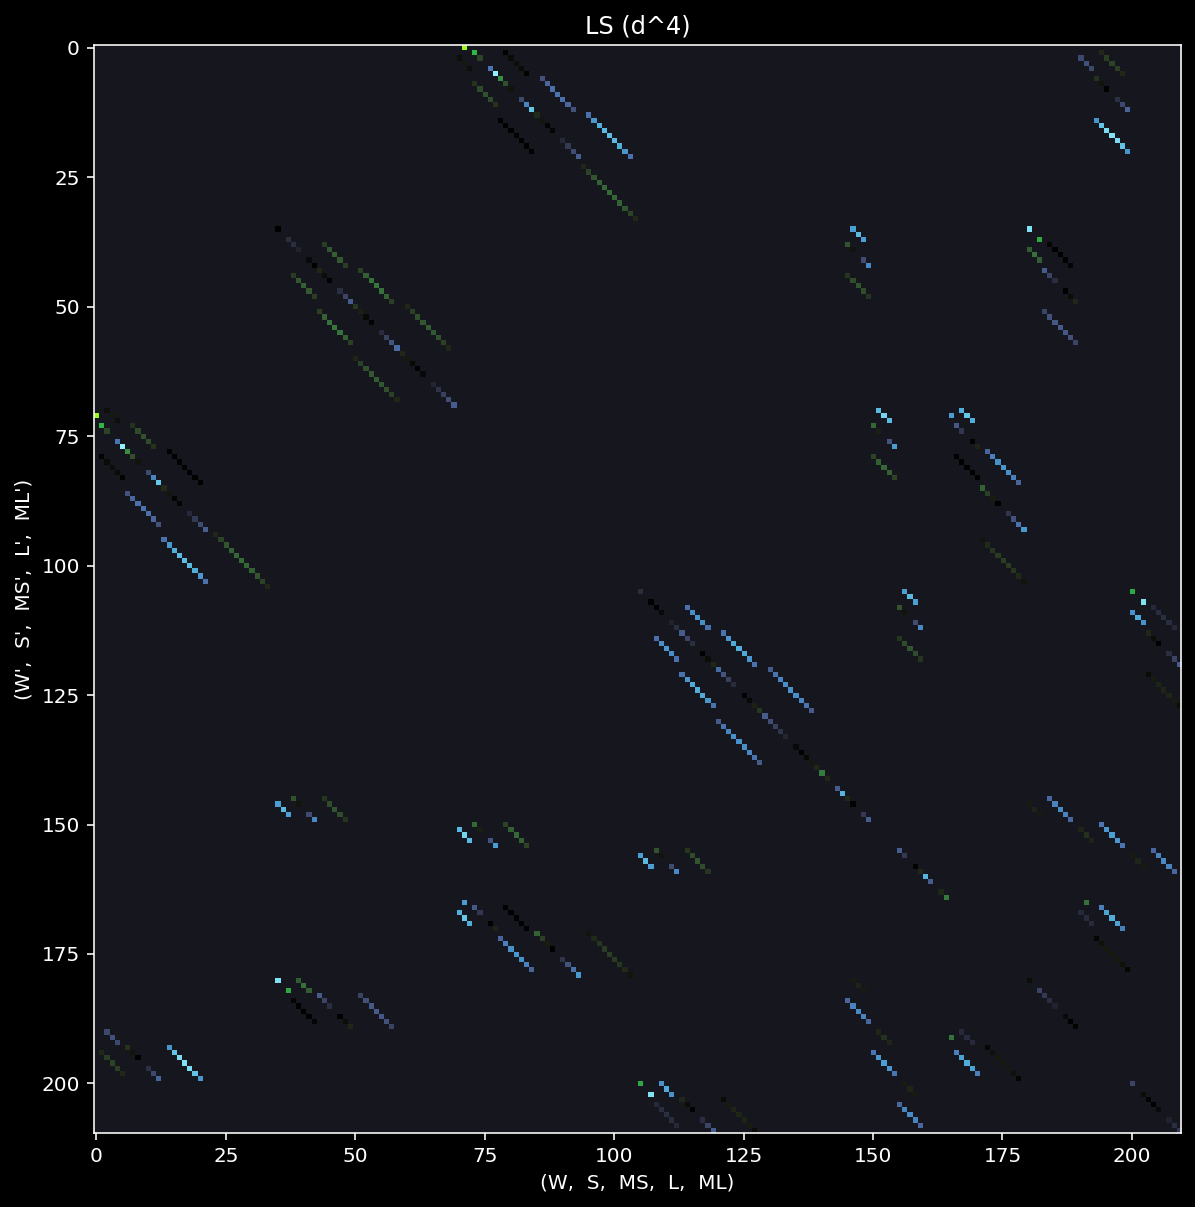

In [202]:
n = 4
ham = H_spin_orbit_LS(2,n,just_the_diagonal=False)
basis = [x for x, y in ham.keys()]
basis = list(set(basis))
basis = list(sorted(basis))
matrix_rep = [[ham[k0,k1] for k1 in basis] for k0 in basis]
matrix_rep = sp.Matrix(matrix_rep)

plt.figure(figsize=(10,10))
plt.imshow(np.array(matrix_rep.subs({sp.Symbol('\zeta'):1})).astype(np.float32), cmap=cm.seaweed)
# plt.colorbar()
plt.title('LS (d^%s)' % n)
plt.xlabel('(W,  S,  MS,  L,  ML)')
plt.ylabel("(W',  S',  MS',  L',  ML')")
plt.show()

In [209]:
def param_ham(ms,ml,msp,mlp):
    if (msp,mlp,ms,ml) in param_ham.memory:
        return sp.conjugate(param_ham.memory[(msp,mlp,ms,ml)] )
    else:
        symbol = sp.Symbol('f({ms},{ml},{msp},{mlp})'.format(ms=ms,ml=ml,msp=msp,mlp=mlp))
        param_ham.memory[(ms,ml,msp,mlp)] = symbol
        return symbol
param_ham.memory = {}

In [210]:
n = 2
ham = one_body_hamiltonian(l,n,param_ham)

In [212]:
basis = [x for x, y in ham.keys()]
basis = list(set(basis))
basis = list(sorted(basis))
matrix_rep = [[ham[k0,k1] for k1 in basis] for k0 in basis]
matrix_rep = sp.Matrix(matrix_rep)

In [ ]:
    terms = 
    terms = list(terms)

In [481]:
def term_range(l,n):
    '''
    Given an electron configuration l^n this
    iterator provides the corresponding terms.
    '''
    terms = all_terms[(all_terms['l'] == l) & (all_terms['n'] == n)][['S','L','idx']].to_records(index=False)
    for term in terms:
        yield term
def ψ_range(term):
    '''
    Given a term this yields the wavefunction
    contained in it
    '''
    S, L, W = term
    ML_s, MS_s = mrange(L), mrange(S)
    for MS, ML in product(MS_s, ML_s):
        Ω  = (W,  S,  MS,  L,  ML) # full address of row state
        yield Ω
def config_range(l,n):
    '''
    '''
    for term in term_range(l,n):
        for Ω in ψ_range(term):
            yield Ω

In [383]:
@lru_cache(maxsize=None)
def Ω_coeff(l, n, Ω, Ωp_1, Ωp_2):
    '''
    This function returns the coefficient
    <lⁿ⁻¹ W* S* MS* L* ML*; l ms ml | lⁿW S MS L ML>
    Parameters
    ----------
    n (int): number of electrons
    Returns
    -------
    '''
    (W,    S,    MS,    L,    ML)    = Ω # daughter
    (W_p,  S_p,  MS_p,  L_p,  ML_p)  = Ωp_1 # parent1
    (W_pp, S_pp, MS_pp, L_pp, ML_pp) = Ωp_2 # parent2
    cfp_args = (l, n,
               S,    L,    W, # daughter term
               S_p,  L_p,  W_p, # parent1 term
               S_pp, L_pp, W_pp) # parent2 term
    # Vector Coupling coeffs
    vcS = VC_coeff((S_p, MS_p, S_pp, MS_pp), 
                      (S_p, S_pp, S,    MS))
    if vcS == 0:
        return 0
    
    vcL = VC_coeff((L_p, ML_p,  L_pp, ML_pp), 
                      (L_p, L_pp, L,    ML))
    if vcL == 0:
        return 0
    
    cfp = CFP_1(*cfp_args, True)
    if cfp == 0:
        return 0
    val = vcS * vcL * cfp
    return val

In [453]:
CFP_2 = CFP_fun(2)

Loading data for 2-body coefficients of fractional parentage...


In [457]:
terms_nm2

[(1/2, 1, 1)]

In [471]:
term_range()

[]

In [484]:
list(term_range(l,n))

[(1/2, 1, 1),
 (1/2, 2, 1),
 (1/2, 2, 2),
 (1/2, 3, 1),
 (1/2, 4, 1),
 (1/2, 5, 1),
 (3/2, 1, 1),
 (3/2, 3, 1)]

In [549]:
list(term_range(l,n))

[(0, 0, 1),
 (0, 0, 2),
 (0, 2, 1),
 (0, 2, 2),
 (0, 3, 1),
 (0, 4, 1),
 (0, 4, 2),
 (0, 6, 1),
 (1, 1, 1),
 (1, 1, 2),
 (1, 2, 1),
 (1, 3, 1),
 (1, 3, 2),
 (1, 4, 1),
 (1, 5, 1),
 (2, 2, 1)]

In [555]:
l, n = 2, 4
two_e_ham = H1(l)

terms = list(term_range(l,n))
# terms = [(sp.S(3)/2,1,1)]
terms = [(0, 0, 1)]

terms_nm2 = list(term_range(l,n-2))
terms_2 = list(term_range(l,2))

ham = dict()
num_iters = 0
k = sp.S(1)/2 * n * (n-1)
for row_term, col_term in product(terms, terms):
    S,  L,  W  = row_term 
    Sp, Lp, Wp = col_term
    # print('S2', end='|')
    for Ω_row, Ω_col in product(ψ_range(row_term), ψ_range(col_term)):
        (W_row, S_row, MS_row, L_row, ML_row) = Ω_row
        (W_col, S_col, MS_col, L_col, ML_col) = Ω_col
        if paired_kron(S_row, S_col, L_row, L_col, MS_row, MS_col, ML_row, ML_col) == 0:
            # ham[(Ω_row, Ω_col)] = 0
            continue
        summands = []
        # here I need to evaluate a sum that ranges over lⁿ⁻² and l²
        for term_2, term_nm2 in product(terms_2, terms_nm2): # iterate over the terms of lⁿ⁻² and l²
            # print("⨳",end=',') 
            S_2,   L_2,   W_2   = term_2 # unpack term_2
            S_nm2, L_nm2, W_nm2 = term_nm2 # unpack term_nm2
            for Ω_2, Ω_nm2 in product(list(ψ_range(term_2)), list(ψ_range(term_nm2))):
                (W_2,   S_2,   MS_2,   L_2,   ML_2)   = Ω_2 # full address of an l² state
                (W_nm2, S_nm2, MS_nm2, L_nm2, ML_nm2) = Ω_nm2 # full address of an lⁿ⁻² state
                # num_iters += 1
                # cfp_args_0 = (l, n,
                #     S_row, L_row, W_row, # daughter term
                #     S_nm2, L_nm2, W_nm2, # parent1 term
                #     S_2,   L_2,   W_2)   # parent2 term
                # fp0 = CFP_2(*cfp_args_0, fill_missing=True)
                # if fp0 == 0:
                #     continue
                # cfp_args_1 = (l, n,
                #     S_row, L_row, W_col, # daughter term
                #     S_nm2, L_nm2, W_nm2, # parent1 term
                #     S_2,   L_2,   W_2)   # parent2 term
                # fp1 = CFP_2(*cfp_args_1, fill_missing=True)
                # if fp1 == 0:
                #     continue
                m2elemn = two_e_ham[(S_2, MS_2, L_2, ML_2,
                                     S_2, MS_2, L_2, ML_2)]
                # summand = fp0 * fp1 * m2elemn * sp.Symbol('\\langle %s,%s|%s,%s;%s,%s\\rangle' % (S,L,S_nm2,L_nm2,S_2,L_2))
                sym = sp.Symbol('\\langle {}^{%s}{%s}|{}^{%s}{%s};{}^{%s}%s\\rangle' % (2*S+1,l_notation_switch(L).upper(),
                                                                                  2*S_nm2+1,l_notation_switch(int(L_nm2)).upper(),
                                                                                  2*S_2+1, l_notation_switch(int(L_2)).upper()))**2
                summand = m2elemn * sym
                summands.append(summand)
        ham_val = sp.simplify(k * sum(summands))
        # ham[(Ω_row, Ω_col)] = ham_val
        ham[(tuple(row_term), tuple(col_term))] = ham_val
print(num_iters)

0


In [546]:
for k,v in ham.items():
    print(k)
    display(sp.simplify(v))

((3/2, 1, 1), (3/2, 1, 1))


150*\langle {}^{4}{P}|{}^{2}{D};{}^{1}D\rangle**2*(-3*F^{(2)} + 4*F^{(4)})/49 + 30*\langle {}^{4}{P}|{}^{2}{D};{}^{1}G\rangle**2*(36*F^{(2)} + F^{(4)})/49 + 60*\langle {}^{4}{P}|{}^{2}{D};{}^{1}S\rangle**2*(F^{(2)} + F^{(4)})/7 - 90*\langle {}^{4}{P}|{}^{2}{D};{}^{3}F\rangle**2*(8*F^{(2)} + F^{(4)})/7 + 90*\langle {}^{4}{P}|{}^{2}{D};{}^{3}P\rangle**2*(3*F^{(2)} - 4*F^{(4)})/7

In [544]:
v.subs({sp.Symbol('F^{(2)}'):0,sp.Symbol('F^{(4)}'):1})

600*\langle {}^{4}{P}|{}^{2}{D};{}^{1}D\rangle/49 + 30*\langle {}^{4}{P}|{}^{2}{D};{}^{1}G\rangle/49 + 60*\langle {}^{4}{P}|{}^{2}{D};{}^{1}S\rangle/7 - 90*\langle {}^{4}{P}|{}^{2}{D};{}^{3}F\rangle/7 - 360*\langle {}^{4}{P}|{}^{2}{D};{}^{3}P\rangle/7

In [346]:
l, n = 2, 3
# Collect the terms of configuration l^n
terms_n = term_range(l,n)

# And the terms for the configuration l^(n-2)
terms_nm2 = term_range(l,n-2)

# And the terms for the configuration l^(2)
terms_2 = term_range(l,2)

ham = dict()

for row_term, col_term in product(terms_n, terms_n):
    # unpack term_row
    S, L, W = row_term 
    # unpack term_col
    Sp, Lp, Wp = col_term
    # make the ranges for ML, MLp, MS, MSp
    ML_s, MLp_s = mrange(L), mrange(Lp)
    MS_s, MSp_s = mrange(S), mrange(Sp)
    for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s):
        Ω  = (W,  S,  MS,  L,  ML) # full address of row state
        Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
        if paired_kron(S, Sp, L, Lp, MS, MSp, ML, MLp) == 0:
            ham[(Ω, Ωp)] = 0
            continue
        summands = []
        for term_2, term_nm2 in product(terms_2, terms_nm2): # iterate over the terms of lⁿ⁻² and l²
            S_2, L_2, W_2 = term_2 # unpack term_2
            MS_2s, ML_2s = mrange(S_2), mrange(L_2)
            S_nm2, L_nm2, W_nm2 = term_nm2 # unpack term_2
            MS_nm2s, ML_nm2s = mrange(S_nm2), mrange(L_nm2)
            for MS_2, ML_2, MS_nm2, ML_nm2 in product(MS_2s, ML_2s, MS_nm2s, ML_nm2s):
                Ωb = (W_2, S_2, MS_2, L_2, ML_2) # full address of an l² state
                Ωbb = (W_nm2, S_nm2, MS_nm2, L_nm2, ML_nm2) # full address of an lⁿ⁻² state
                Ωpp = (Wp, S,  MS,  L,  ML) # full address of col state
                num_iters += 1
                fp0 = Ω_coeff(l, n, Ω, Ωbb, Ωb)
                if fp0 == 0:
                    continue
                fp1 = Ω_coeff(l, n, Ωpp, Ωbb, Ωbp)
                if fp1 == 0:
                    continue
                summands.append(fp0 * fp1)
        

ZeroDivisionError: float division by zero

In [332]:
# '''
# a
# '''
# l, n = 2, 3
# # Collect the terms of configuration l^n
# terms_n = all_terms[(all_terms['l'] == l) & (all_terms['n'] == n)][['S','L','idx']].to_records(index=False)
# terms_n = list(terms_n)

# # And the terms for the configuration l^(n-2)
# terms_nm2 = all_terms[(all_terms['l'] == l) & (all_terms['n'] == (n-2))][['S','L','idx']].to_records(index=False)
# terms_nm2 = list(terms_nm2)

# # And the terms for the configuration l^(2)
# terms_2 = all_terms[(all_terms['l'] == l) & (all_terms['n'] == 2)][['S','L','idx']].to_records(index=False)
# terms_2 = list(terms_2)

# ham = dict()

# for row_term, col_term in product(terms_n, terms_n):
#     # unpack term_row
#     S, L, W = row_term 
#     # unpack term_col
#     Sp, Lp, Wp = col_term
#     # make the ranges for ML, MLp, MS, MSp
#     ML_s, MLp_s = mrange(L), mrange(Lp)
#     MS_s, MSp_s = mrange(S), mrange(Sp)
#     for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s):
#         Ω  = (W,  S,  MS,  L,  ML) # full address of row state
#         Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
#         if paired_kron(S, Sp, L, Lp, MS, MSp, ML, MLp) == 0:
#             ham[(Ω, Ωp)] = 0
#             continue
#         summands = []
#         for term_2, term_nm2 in product(terms_2, terms_nm2): # iterate over the terms of lⁿ⁻² and l²
#             S_2, L_2, W_2 = term_2 # unpack term_2
#             MS_2s, ML_2s = mrange(S_2), mrange(L_2)
#             S_nm2, L_nm2, W_nm2 = term_nm2 # unpack term_2
#             MS_nm2s, ML_nm2s = mrange(S_nm2), mrange(L_nm2)
#             for MS_2, ML_2, MS_nm2, ML_nm2 in product(MS_2s, ML_2s, MS_nm2s, ML_nm2s):
#                 Ωb = (W_2, S_2, MS_2, L_2, ML_2) # full address of an l² state
#                 Ωbb = (W_nm2, S_nm2, MS_nm2, L_nm2, ML_nm2) # full address of an lⁿ⁻² state
#                 Ωpp = (Wp, S,  MS,  L,  ML) # full address of col state
#                 num_iters += 1
#                 fp0 = Ω_coeff(l, n, Ω, Ωbb, Ωb)
#                 if fp0 == 0:
#                     continue
#                 fp1 = Ω_coeff(l, n, Ωpp, Ωbb, Ωbp)
#                 if fp1 == 0:
#                     continue
#                 summands.append(fp0 * fp1)
        

KeyError: (2, 2, 1/2, 2, 1)

<center> <img src="notebook_imgs/2022-04-23-07-08-49.png" style="width: 50%;"/> </center>

In [321]:
from misc import labeled_matrix

In [327]:
def labeled_matrix(a_matrix, basis_labels=[], elbow='', show=True):
    '''
    Parameters
    ----------
    a_matrix (sp.Matrix of list): square matrix of nested list.
    basis_labels (list[(str)])  : list of string representing labels for the basis kets.
    display (bool): if True then the resulting LaTeX expression is displayed.
    elbow (str) : text display in the top left corner, preferable a math expression.

    If basis_labels is empty then a sequence of integers are used for the labels.
    Returns
    -------
    a_matrix (sp.Matrix) : matrix with added row and column to represent the basis labels.
    '''
    from IPython.display import display, Math
    if isinstance(a_matrix, sp.Matrix):
        a_matrix = a_matrix.tolist()
    if len(basis_labels) == 0:
        basis_labels = list(range(len(a_matrix)))
    num_rows = len(a_matrix)
    assert len(a_matrix) == len(a_matrix[0]), "Matrix is not square."
    assert len(basis_labels) == len(a_matrix), "Basis and matrix dimensions mismatch."
    basis_kets = [sp.Symbol( '|{%s}\\rangle' % bl) for bl in basis_labels]
    basis_bras = [sp.Symbol('\\langle{%s}|' % bl) for bl in basis_labels]
    a_matrix = [[bk]+row for bk, row in zip(basis_bras,a_matrix)]
    extra_row = [sp.Symbol(elbow)]+basis_kets
    a_matrix = sp.latex(sp.Matrix([extra_row]+a_matrix))
    a_matrix = a_matrix.replace('c'*num_rows,('c'*num_rows).replace('c','c|',1)).replace('\\\\','\\\\[0.2cm] \\hline \\\\[-0.2cm] ', 1).replace('\\left[','',1).replace('\\right]','')
    if show:
        display(Math(a_matrix))
    return a_matrix

In [329]:
a_matrix = sp.Matrix([[sp.sqrt(i*j) for i in range(20)] for j in range(20)])
basis_labels = 'α β γ δ ε ω ζ η ξ υ α β χ δ ε ω ζ η ξ υ'.split(' ')
a_l_matrix = labeled_matrix(a_matrix, basis_labels, 'J=3')

<IPython.core.display.Math object>

In [ ]:
# for term_row, term_col in product(terms, terms): # loop over the terms for rows and columns
#     # unpack term_row
#     S, L, W = term_row 
#     # unpack term_col
#     Sp, Lp, Wp = term_col
#     # make the ranges for ML, MLp, MS, MSp
#     ML_s, MLp_s = mrange(L), mrange(Lp)
#     MS_s, MSp_s = mrange(S), mrange(Sp)
#     for MS, ML, MSp, MLp in product(MS_s, ML_s, MSp_s, MLp_s): # this loops over the enclosed states
#         Ω  = (W,  S,  MS,  L,  ML) # full address of row state
#         Ωp = (Wp, Sp, MSp, Lp, MLp) # full address of col state
#         if just_the_diagonal:
#             if Ω != Ωp:
#                 continue
#         summands = []
#         num_iters = 0
#         for term_bar in term_bar_s: # iterate over the terms of lⁿ⁻¹
#             Sb, Lb, Wb = term_bar # unpack term_bar
#             MSb_s, MLb_s = mrange(Sb), mrange(Lb)
#             for MSb, MLb in product(MSb_s, MLb_s):
#                 Ωb = (Wb, Sb, MSb, Lb, MLb) # full address of an lⁿ⁻¹ state
#                 for ml, ms in product(mls, Ms_s): # Σ ω, ωp assumming δ(ml,mlp)δ(ms,msp)
#                     mlp, msp = ml, ms
#                     num_iters += 1
#                     ω =  (1, HALF, ms,  l, ml)
#                     ωp = (1, HALF, msp, l, mlp)
#                     fp0 = Ω_coeff(l, n, Ω, Ωb, ω)
#                     if fp0 == 0:
#                         continue
#                     fp1 = Ω_coeff(l, n, Ωp, Ωb, ωp)
#                     if fp1 == 0:
#                         continue
#                     summand = fp0 * fp1 * ham_single(ms,ml,msp,mlp)
#                     summands.append(summand)
#         one_body_ham[(Ω, Ωp)] = n*sum(summands)
# return one_body_ham

# LS bases (Apr-27 2022-04-27 10:16:29)

Create the multi-electron bases |L,S,ML,MS⟩ explicitly using the one-body coefficients of fractional parentage. Results are saved as dictionaries that are keyed by 4-tuples (L,S,ML,MS) and whose values are qets whose keys are 2n-tuples (ml_1, ms_1, ml_2, ms_2, ... ml_n, ms_n) whose coefficients are symbolic expressions for the coefficients.

Going beyond the half-filled shell states is unnecessary but it's done here nonetheless.

## Loops and loops

In [ ]:
# up to half-filled
Ψs_1 = {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }

l , n = 2, 2
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
Ψs_2 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Qet({(ML_bar, MS_bar):1})
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_2[Ω] = full_qet

l , n = 2, 3
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
Ψs_3 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Ψs_2[(Ω_bar)]
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_3[Ω] = full_qet

l , n = 2, 4
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
Ψs_4 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Ψs_3[(Ω_bar)]
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_4[Ω] = full_qet

l , n = 2, 5
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
Ψs_5 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Ψs_4[(Ω_bar)]
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_5[Ω] = full_qet

In [100]:
# from half-filled onwards
# this takes about 6 minutes
l , n = 2, 6
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
# initally I will develop this assuming that n is 2
# in which case the basis for n-1 is trivial
Ψs_6 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Ψs_5[(Ω_bar)]
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_6[Ω] = full_qet

# this takes about 20 minutes to run
l , n = 2, 7
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
# initally I will develop this assuming that n is 2
# in which case the basis for n-1 is trivial
Ψs_7 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Ψs_6[(Ω_bar)]
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_7[Ω] = full_qet

# this takes about 110 minutes to run
l , n = 2, 8
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
# initally I will develop this assuming that n is 2
# in which case the basis for n-1 is trivial
Ψs_8 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Ψs_7[(Ω_bar)]
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_8[Ω] = full_qet

# this takes about 340 minutes to run
l , n = 2, 9
terms_n = list(to.term_range(l, n))
terms_nm1 = list(to.term_range(l, n-1))
# initally I will develop this assuming that n is 2
# in which case the basis for n-1 is trivial
Ψs_9 = {} # this will be a dictionary of qets, these are all determinantal qets
for term_n in terms_n: # for each term there will be a bunch of wavefunctions
    ψ_key = term_n
    S_n, L_n, W_n = term_n
    for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
        Ω = (W_n, S_n, MS_n, L_n, ML_n)
        summands = []
        for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
            Ω_1 = (1, to.HALF, ms, l, ml)
            for term_nm1 in terms_nm1:
                for Ω_bar in to.ψ_range(term_nm1):
                    (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                    Ω_bar_qet = Ψs_8[(Ω_bar)]
                    coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                    if coeff:
                        qet = coeff*Qet({(ml,ms):1})*Ω_bar_qet
                        summands.append(qet)
        full_qet = sum(summands,Qet({}))
        Ψs_9[Ω] = full_qet

Loading data for 1-body coefficients of fractional parentage...


In [160]:
LS_Ψs = {1: Ψs_1, 2: Ψs_2, 3: Ψs_3, 4: Ψs_4, 5: Ψs_5, 6: Ψs_6, 7: Ψs_7, 8: Ψs_8, 9: Ψs_9}
LS_Ψs = {num_e: {k:ψ.dict for k,ψ in Ψs.items()} for num_e, Ψs in LS_Ψs.items()}

In [161]:
from misc import split_dump

In [162]:
pickle.dump(LS_Ψs, open('./data/LS_qets_1_to_9.pkl','wb'))
split_dump(LS_Ψs, 'LS_qets_1_to_9', './data/', 90)

Object pickled to 6 file(s).


In [157]:
LS_Ψs = {1: Ψs_1, 2: Ψs_2, 3: Ψs_3, 4: Ψs_4, 5: Ψs_5}
LS_Ψs = {num_e: {k:ψ.dict for k,ψ in Ψs.items()} for num_e, Ψs in LS_Ψs.items()}
pickle.dump(LS_Ψs, open('./data/LS_qets_1_to_5.pkl','wb'))

## Neat loop

In [251]:
# up to half-filled

l = 2
n_max = (2*l+1)
n_max = 4

LS_Ψs = {}
LS_Ψs[1] = {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    # this will be a dictionary of qets
    Ψs_next = {} 
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
            Ω = (W_n, S_n, MS_n, L_n, ML_n)
            summands = []
            for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
                Ω_1 = (1, to.HALF, ms, l, ml)
                for term_nm1 in terms_nm1:
                    for Ω_bar in to.ψ_range(term_nm1):
                        (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                        Ω_bar_qet = LS_Ψs[n-1][(Ω_bar)]
                        coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                        if coeff:
                            qet = coeff * (Ω_bar_qet * Qet({(ml,ms):1}))
                            summands.append(qet)
            full_qet = sum(summands,Qet({}))
            Ψs_next[Ω] = full_qet
    LS_Ψs[n] = Ψs_next


> Building LSMLMS determinantal qets for d^2
> Building LSMLMS determinantal qets for d^3
> Building LSMLMS determinantal qets for d^4


In [ ]:
# v 1 10.2
# shortcircuit 1.2s
# shortcircuit 2.8s
# adding as it goes along 10.7
# parallelized 3.9s

### alternatives

In [254]:
# # shortcircuit
# up to half-filled

l = 2
n_max = (2*l+1)
n_max = 4

LS_Ψs = {}
LS_Ψs[1] = {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    # this will be a dictionary of qets
    Ψs_next = {} 
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
            Ω = (W_n, S_n, MS_n, L_n, ML_n)
            summands = []
            for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
                Ω_1 = (1, to.HALF, ms, l, ml)
                for term_nm1 in terms_nm1:
                    for Ω_bar in to.ψ_range(term_nm1):
                        (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                        Ω_bar_qet = LS_Ψs[n-1][(Ω_bar)]
                        # coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                        continue
                        if coeff:
                            qet = coeff * (Ω_bar_qet * Qet({(ml,ms):1}))
                            summands.append(qet)
            full_qet = sum(summands,Qet({}))
            Ψs_next[Ω] = full_qet
    LS_Ψs[n] = Ψs_next


> Building LSMLMS determinantal qets for d^2
> Building LSMLMS determinantal qets for d^3
> Building LSMLMS determinantal qets for d^4


In [256]:
# # shortcircuit with coeff
# up to half-filled

l = 2
n_max = (2*l+1)
n_max = 4

LS_Ψs = {}
LS_Ψs[1] = {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    # this will be a dictionary of qets
    Ψs_next = {} 
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
            Ω = (W_n, S_n, MS_n, L_n, ML_n)
            summands = []
            for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
                Ω_1 = (1, to.HALF, ms, l, ml)
                for term_nm1 in terms_nm1:
                    for Ω_bar in to.ψ_range(term_nm1):
                        (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                        Ω_bar_qet = LS_Ψs[n-1][(Ω_bar)]
                        coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                        if coeff:
                            qet = coeff * (Ω_bar_qet * Qet({(ml,ms):1}))
                            summands.append(qet)
            full_qet = sum(summands,Qet({}))
            Ψs_next[Ω] = full_qet
    LS_Ψs[n] = Ψs_next


> Building LSMLMS determinantal qets for d^2
> Building LSMLMS determinantal qets for d^3
> Building LSMLMS determinantal qets for d^4


In [290]:
# # adding as it goes along
# up to half-filled

l = 2
n_max = (2*l+1)
n_max = 4

LS_Ψs = {}
LS_Ψs[1] = {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    # this will be a dictionary of qets
    Ψs_next = {} 
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        for MS_n , ML_n in product(to.mrange(S_n), to.mrange(L_n)):
            Ω = (W_n, S_n, MS_n, L_n, ML_n)
            qet = Qet({})
            for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
                Ω_1 = (1, to.HALF, ms, l, ml)
                for term_nm1 in terms_nm1:
                    for Ω_bar in to.ψ_range(term_nm1):
                        (W_bar, S_bar, MS_bar, L_bar, ML_bar) = Ω_bar
                        Ω_bar_qet = LS_Ψs[n-1][(Ω_bar)]
                        coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                        if coeff:
                            qet = qet + coeff * (Ω_bar_qet * Qet({(ml,ms):1}))
            Ψs_next[Ω] = qet
    LS_Ψs[n] = Ψs_next


> Building LSMLMS determinantal qets for d^2


## Parallelized

In [311]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [338]:
def ψ_baker(l, n, S_n, L_n, W_n, MS_n , ML_n, ψs_nm1, terms_nm1):
    Ω = (W_n, S_n, MS_n, L_n, ML_n)
    qet = Qet({})
    for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
        Ω_1 = (1, to.HALF, ms, l, ml)
        for term_nm1 in terms_nm1:
            for Ω_bar in to.ψ_range(term_nm1):
                Ω_bar_qet = ψs_nm1[(Ω_bar)]
                coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                if coeff:
                    qet = qet + coeff * (Ω_bar_qet * Qet({(ml,ms):1}))
    return (Ω, qet)

In [ ]:
l = 2
n_max = (2*l+1)
n_max = 4

LS_Ψs = {}
LS_Ψs[1] = {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    start_time = time()
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    # this will be a dictionary of qets
    all_qets = []
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        qets = Parallel(n_jobs = num_cores)(delayed(ψ_baker)(l, n, S_n, L_n, W_n, MS_n, ML_n, LS_Ψs[n-1], terms_nm1) for (MS_n, ML_n) in product(to.mrange(S_n), to.mrange(L_n)))
        all_qets.extend(qets)
    LS_Ψs[n] = dict(all_qets)
    end_time = time()
    print(">> Time taken: %.1f minutes." % ((end_time-start_time)/60))


In [321]:
LS_Ψs = {num_e: {k:ψ.dict for k,ψ in Ψs.items()} for num_e, Ψs in LS_Ψs.items()}
pickle.dump(LS_Ψs, open('./data/LS_qets_1_to_5.pkl','wb'))

In [ ]:
# this takes about 30 minutes to run
l = 2
n_max = 2*(2*l+1) - 1

LS_Ψs = {}
LS_Ψs[1] = {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    start_time = time()
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    all_qets = {}
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        qets = Parallel(n_jobs = num_cores)(delayed(ψ_baker)(l, n, S_n, L_n, W_n, MS_n, ML_n, LS_Ψs[n-1], terms_nm1) for (MS_n, ML_n) in product(to.mrange(S_n), to.mrange(L_n)))
        all_qets[tuple(term_n)] = qets
    LS_Ψs[n] = all_qets
    end_time = time()
    print(">> Time taken: %.1f minutes." % ((end_time-start_time)/60))


In [323]:
list(map(len,LS_Ψs.values())) 

[10, 45, 120, 210, 252, 210, 120, 45, 10]

In [324]:
LS_Ψs = {num_e: {k:ψ.dict for k,ψ in Ψs.items()} for num_e, Ψs in LS_Ψs.items()}
pickle.dump(LS_Ψs, open('./data/LS_qets_1_to_9.pkl','wb'))
split_dump(LS_Ψs, 'LS_qets_1_to_9', './data/', 90)

Removed 6 previous matching files.
Object pickled to 6 file(s).


## Parallelized with term keys (moved to script LS_basis_gen.py)

In [359]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [375]:
def ψ_baker(l, n, S_n, L_n, W_n, MS_n , ML_n, ψs_nm1, terms_nm1):
    Ω = (W_n, S_n, MS_n, L_n, ML_n)
    qet = Qet({})
    for ml, ms in product(to.mrange(l), to.mrange(to.HALF)):
        Ω_1 = (1, to.HALF, ms, l, ml)
        for term_nm1 in terms_nm1:
            for Ω_bar in to.ψ_range(term_nm1):
                term_bar = (Ω_bar[1], Ω_bar[3], Ω_bar[0])
                Ω_bar_qet = ψs_nm1[term_bar][Ω_bar]
                coeff = to.Ω_coeff(l,n, Ω, Ω_bar, Ω_1)
                if coeff:
                    qet = qet + coeff * (Ω_bar_qet * Qet({(ml,ms):1}))
    return (Ω, qet)

In [391]:
l = 2
n_max = (2*l+1)

LS_Ψs = {}
LS_Ψs[1] = {(to.HALF,l,1): {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }}

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    start_time = time()
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    all_qets = {}
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        term_n = tuple(term_n)
        qets = Parallel(n_jobs = num_cores)(delayed(ψ_baker)(l, n, S_n, L_n, W_n, MS_n, ML_n, LS_Ψs[n-1], terms_nm1) for (MS_n, ML_n) in product(to.mrange(S_n), to.mrange(L_n)))
        all_qets[term_n] = dict(qets)
    LS_Ψs[n] = all_qets
    end_time = time()
    print(">> Time taken: %.2f minutes." % ((end_time-start_time)/60))


> Building LSMLMS determinantal qets for d^2
>> Time taken: 0.00 minutes.
> Building LSMLMS determinantal qets for d^3
>> Time taken: 0.01 minutes.
> Building LSMLMS determinantal qets for d^4
>> Time taken: 0.04 minutes.
> Building LSMLMS determinantal qets for d^5
>> Time taken: 0.31 minutes.


In [392]:
LS_Ψs = {num_e: {term: {k:ψ.dict for k,ψ in Ψs[term].items()} for term in Ψs} for num_e, Ψs in LS_Ψs.items()}
pickle.dump(LS_Ψs, open('./data/LS_qets_1_to_5.pkl','wb'))

In [393]:
l = 2
n_max = 2*(2*l+1) - 1

LS_Ψs = {}
LS_Ψs[1] = {(to.HALF,l,1): {(1, to.HALF, ms, l, ml): Qet({(ml,ms):1}) for ml,ms in product(to.mrange(l), to.mrange(to.HALF)) }}

for n in range(2, n_max+1):
    print("> Building LSMLMS determinantal qets for %s^%d" % (l_notation_switch(l).lower(),n))
    start_time = time()
    terms_n = list(to.term_range(l, n))
    terms_nm1 = list(to.term_range(l, n-1))
    all_qets = {}
    for term_n in terms_n: # for each term there will be a bunch of wavefunctions
        ψ_key = term_n
        S_n, L_n, W_n = term_n
        term_n = tuple(term_n)
        qets = Parallel(n_jobs = num_cores)(delayed(ψ_baker)(l, n, S_n, L_n, W_n, MS_n, ML_n, LS_Ψs[n-1], terms_nm1) for (MS_n, ML_n) in product(to.mrange(S_n), to.mrange(L_n)))
        all_qets[term_n] = dict(qets)
    LS_Ψs[n] = all_qets
    end_time = time()
    print(">> Time taken: %.2f minutes." % ((end_time-start_time)/60))


> Building LSMLMS determinantal qets for d^2
>> Time taken: 0.00 minutes.
> Building LSMLMS determinantal qets for d^3
>> Time taken: 0.01 minutes.
> Building LSMLMS determinantal qets for d^4
>> Time taken: 0.06 minutes.
> Building LSMLMS determinantal qets for d^5
>> Time taken: 0.36 minutes.
> Building LSMLMS determinantal qets for d^6
>> Time taken: 1.86 minutes.
> Building LSMLMS determinantal qets for d^7
>> Time taken: 6.55 minutes.
> Building LSMLMS determinantal qets for d^8
>> Time taken: 10.65 minutes.
> Building LSMLMS determinantal qets for d^9
>> Time taken: 6.96 minutes.


In [414]:
list({1:(2,2),3:4}.items())

[(1, (2, 2)), (3, 4)]

In [397]:
LS_Ψs = {num_e: {term: {k:ψ for k,ψ in Ψs[term].items()} for term in Ψs} for num_e, Ψs in LS_Ψs.items()}
pickle.dump(LS_Ψs, open('./data/LS_qets_1_to_9.pkl','wb'))
split_dump(LS_Ψs, 'LS_qets_1_to_9', './data/', 90)

Removed 6 previous matching files.
Object pickled to 6 file(s).


In [418]:
import pickle
data= pickle.load(open('./data/LS_qets_1_to_3.pkl','rb'))

In [425]:
data[2][(0,0,1)][(1,0,0,0,0)][0][0][0]

2